In [1]:
import pandas as pd

In [2]:
train_market = pd.read_csv('../../data/raw/first_round_train_market_data.csv')
test_market = pd.read_csv('../../data/raw/first_round_test_market_data.csv')
all_market = pd.concat([train_market, test_market])
all_market.to_csv('../../data/raw_long/first_round_train_market_data.csv')

In [4]:
train_fundamental = pd.read_csv('../../data/raw/first_round_train_fundamental_data.csv')
test_fundamental = pd.read_csv('../../data/raw/first_round_test_fundamental_data.csv')
all_fundamental = pd.concat([train_fundamental, test_fundamental])
all_fundamental.to_csv('../../data/raw_long/first_round_train_fundamental_data.csv')

In [12]:
train_return = pd.read_csv('../../data/raw/first_round_train_return_data.csv')


In [27]:
from pandas import Series

all_returns = []
for day in range(1, 1698):
    r_values = all_market.iloc[50*54*(day+2)-54:50*54*(day+2)]['close'].values / all_market.iloc[50*54*day-54:50*54*day]['close'].values - 1
    d_values = all_market.iloc[50*54*day-54:50*54*day]['date_time'].str.split('p', expand=True).iloc[:, 0].rename('date_time')
    all_returns.append(Series(data=r_values, index=d_values, name='return'))

In [28]:
my_return = pd.concat(all_returns)

In [34]:
my_return.to_csv('../../data/raw_long/first_round_train_return_data.csv')

In [35]:
import pipeline
from pipeline.parse_raw_df import pre_process_df_with_date, pre_process_df_with_date_time

parsed_path = '../../data/parsed_long'
raw_path = '../../data/raw_long'
template = '{}/first_round_train_{}_data.csv'

f_df = pre_process_df_with_date(pd.read_csv(template.format(raw_path, 'fundamental')))
m_df = pre_process_df_with_date_time(pd.read_csv(template.format(raw_path, 'market')))
r_df = pre_process_df_with_date(pd.read_csv(template.format(raw_path, 'return')))
pipeline.Dataset(m_df, f_df, r_df).dump(parsed_path)

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series
from sklearn.linear_model import LinearRegression

from pipeline.parse_raw_df import pre_process_df_with_date_time, pre_process_df_with_date
from datatools import data_quantization, extract_market_data
from pipeline import Dataset, N_train_days, N_test_days, N_asset, N_timeslot
from pipeline.backtest import cross_validation, evaluation_for_submission
from visualization.metric import plot_performance

from tqdm.auto import trange
from qids_lib import QIDS

In [37]:
dataset = Dataset.load('../../data/parsed_long')
# qids = QIDS(path_prefix='../../')

In [38]:
m_intraday_df = extract_market_data(dataset.market)
df = pd.concat([dataset.fundamental, m_intraday_df], axis=1)
df_with_return = pd.concat([dataset.fundamental, m_intraday_df, dataset.ref_return], axis=1).dropna()

In [39]:
features = ['turnoverRatio', 'transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf']

In [40]:
def linear_model(X, y):
    reg = LinearRegression().fit(X, y)
    return reg

In [48]:
performance = cross_validation(linear_model, features, df_with_return.loc[(range(1000, 1697),)], n_splits=696, lookback_window=200)

  0%|          | 0/696 [00:00<?, ?it/s]

The ending score for metric train_r2 is: 1.8458e-03
The ending score for metric val_cum_r2 is: -9.3028e-03
The ending score for metric val_cum_pearson is: 4.1438e-02


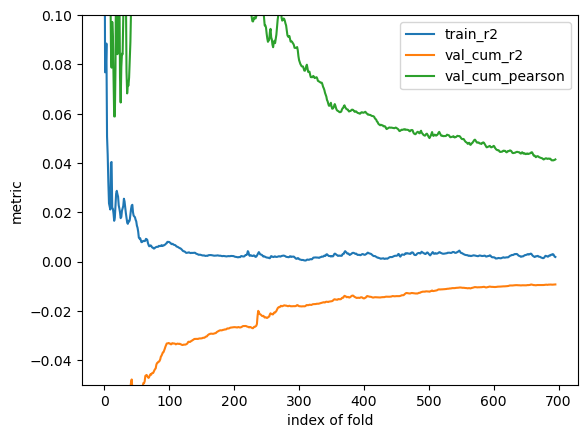

In [49]:
plt.figure()
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
plt.show()